# Final Project, DM Task 3

## Imported Libraries

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, completeness_score, homogeneity_score, accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

## Smoking Dataset

Data Source: https://www.kaggle.com/datasets/gauravduttakiit/smoker-status-prediction-using-biosignals/data

### Data Set Information

Our dataset, Smoker Status Prediction using Bio-Signals, contains 22 features and 2 classes (smoker not
smoker). It’s a total of ~ 3 MB. It has the following features:
Age (years), height (cm), weight (kg), waist (cm), eyesight (left eye), eyesight (right eye), hearing (left
ear), hearing (right ear), systolic, relaxation, fasting blood sugar, Cholesterol, HDL, LDL, hemoglobin,
Urine protein, serum creatinine, AST, ALT, Gtp, dental caries.
Here are some additional notes about the variables included in the dataset. The values for the age variable
are rounded to the nearest multiple of 5. The waist variable represents the circumference of the
individual’s waist. The systolic variable measures an individual’s maximum blood pressure during a
single heartbeat. The relaxation variable measures an individual’s blood pressure between heartbeats. The
Cholesterol variable measures an individual’s total triglyceride. The HDL and LDL variables are
measures of different types of cholesterol. The AST and ALT variablesrepresent the glutamic oxaloacetic
transaminase type. The Gtp variable represents the γ-GTP for an individual. The dental caries and
smoking variables contain binary values.
Our classification model will aim to predict values for the smoking variable. Our dataset contains 24,666
instances of nonsmokers and 14,318 instances of smokers.

### Variable Info

- **age** : 5-years gap
- **height**(cm)
- **weight**(kg)
- **waist**(cm) : Waist circumference length
- **eyesight**(left)
- **eyesight**(right)
- **hearing**(left)
- **hearing**(right)
- **systolic** : Blood pressure
- **relaxation** : Blood pressure
- **fasting blood sugar**
- **Cholesterol** : total
- **triglyceride**
- **HDL** : cholesterol type
- **LDL** : cholesterol type
- **hemoglobin**
- **Urine protein**
- **serum creatinine**
- **AST** : glutamic oxaloacetic transaminase type
- **ALT** : glutamic oxaloacetic transaminase type
- **Gtp** : γ-GTP
- **dental caries**
- **smoking**: label for this dataset. 0 = non-smoker, and 1 = smoker

## Preprocess

In [4]:
smoker_df = pd.read_csv("data/kaggle_smoker_dataset.csv")

In [5]:
na_row_count = smoker_df.isna().sum(axis=1)
print("Number of rows with NA values:", na_row_count.sum())

Number of rows with NA values: 0


Separate our class labels from the full dataset into it's own df

In [6]:
# if cell is ran twice it will fail - try excepts handles that error
try:
    labels_df = smoker_df["smoking"]
    smoker_df.drop(["smoking"], axis=1, inplace=True)
except KeyError as e:
    pass

label_names = ["non-smoker", "smoker"] # 0 = non-smoker and 1 = smoker

### Normalize

apply min max scaling

In [7]:
# Min-Max scaling
min_max_scaler = MinMaxScaler()
smoker_df_scaled = min_max_scaler.fit_transform(smoker_df)

### Train/Validation/Test split

In [8]:
train_df, test_df, train_labels_df, test_labels_df = train_test_split(smoker_df_scaled, labels_df, test_size=0.2, random_state=33, stratify=labels_df)
train_df, valid_df, train_labels_df, valid_labels_df = train_test_split(train_df, train_labels_df, test_size=0.2, random_state=33, stratify=train_labels_df)

## Linear SVM Classifier

I chose to use an SVM classifier because of the analysis done in EDA where we looked at the data in a 2D plane using PCA. The data looked like it had structure that an SVM will be able to seperate.

### SVM Base Model

In [9]:
# Create an SVM classifier
base_svm = SVC(kernel='linear', random_state=42)

# Train the SVM classifier
base_svm.fit(train_df, train_labels_df)

# Predict the labels for the test data
predictions = base_svm.predict(valid_df)

# Calculate the accuracy of the model
accuracy = accuracy_score(valid_labels_df, predictions)
print("Accuracy:", accuracy)

Accuracy: 0.7281179865341456


The base model does fairly well, but this can be improved by changing the hyper parameters

## Tuning the Linear SVM Classifier

### Using Grid Search to tune

In [ ]:
# Define the parameter grid
C_values = [0.001, 0.01, 0.1, 1, 10, 100]
param_grid = {
    'C': C_values,  # Regularization parameter
}

# Create an SVM classifier
svm_classifier = SVC(kernel='linear', random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=svm_classifier, param_grid=param_grid, cv=3)
grid_search.fit(train_df, train_labels_df)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'C': 100}


### Plotting the Results

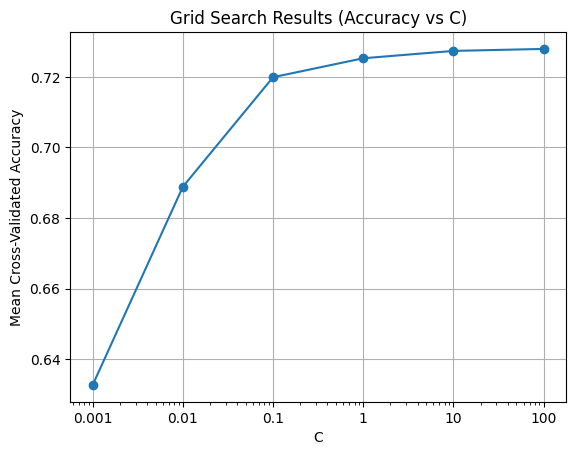

In [ ]:
# Get the mean cross-validated accuracy for each value of C
mean_scores = grid_search.cv_results_['mean_test_score']

# Plot the results as a line plot
plt.plot(C_values, mean_scores, marker='o', linestyle='-')
plt.xlabel('C')
plt.ylabel('Mean Cross-Validated Accuracy')
plt.title('Grid Search Results (Accuracy vs C)')
plt.xscale('log')
plt.xticks(C_values, C_values)
plt.grid(True)
plt.show()

After C=10, the accuracy starts to level off, meaning at that point the hyper param is best

### Eval on val split

In [ ]:
# Predict the labels for the test data using the best model
best_model = grid_search.best_estimator_
predictions = best_model.predict(valid_df)

# Calculate the accuracy of the best model
accuracy = accuracy_score(valid_labels_df, predictions)
print("Accuracy:", accuracy)

# Calculate the F1 score of the best model
f1 = f1_score(valid_labels_df, predictions)
print("F1 Score:", f1)

Accuracy: 0.731484450144277
F1 Score: 0.625865534956444


After tuning the model did ~0.01 better. Both validation and training received a similiar accuracy score so there is no sign of overfitting.

In [ ]:
print(classification_report(valid_labels_df, predictions, target_names=label_names))

              precision    recall  f1-score   support

  non-smoker       0.78      0.80      0.79      3947
      smoker       0.64      0.61      0.63      2291

    accuracy                           0.73      6238
   macro avg       0.71      0.71      0.71      6238
weighted avg       0.73      0.73      0.73      6238



### What features were important?

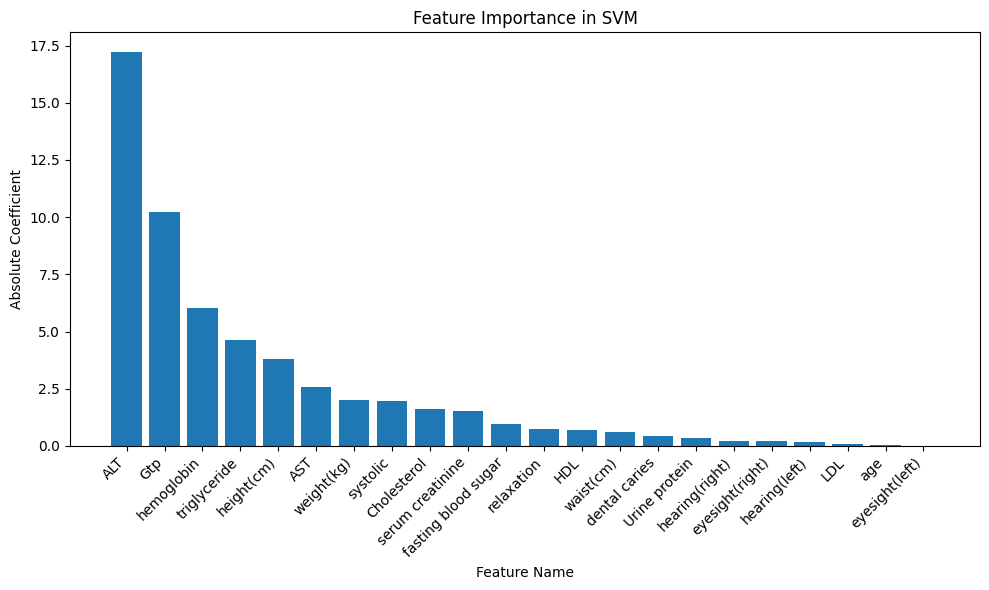

In [ ]:
# Extract the learned coefficients from the SVM model
coefficients = best_model.coef_.ravel()

# Get the absolute values of coefficients to capture the importance regardless of direction
abs_coefficients = np.abs(coefficients)

# Get the names of the features from the DataFrame
feature_names = smoker_df.columns

# Sort the coefficients and corresponding feature names in descending order of importance
sorted_indices = np.argsort(abs_coefficients)[::-1]
sorted_coefficients = abs_coefficients[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

# Plot the importance of features
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_feature_names)), sorted_coefficients)
plt.xticks(range(len(sorted_feature_names)), sorted_feature_names, rotation=45, ha='right')
plt.xlabel('Feature Name')
plt.ylabel('Absolute Coefficient')
plt.title('Feature Importance in SVM')
plt.tight_layout()
plt.show()

I am going to redo the svm but remove features that were not as important in the model.

## Linear SVM Classifier With Feature Reduction

In [ ]:
#drop not imporant features
drop_feat= ['age',
            'eyesight(left)',
            'eyesight(right)',
            'hearing(left)',
            'hearing(right)',
            'LDL',
            'Urine protein',
            'dental caries']

temp = smoker_df.drop(columns= drop_feat)

# Min-Max scaling
min_max_scaler = MinMaxScaler()
temp_scaled = min_max_scaler.fit_transform(temp)

# split
t_train_df, t_test_df, t_train_labels_df, t_test_labels_df = train_test_split(temp_scaled, labels_df, test_size=0.2, random_state=33, stratify=labels_df)
t_train_df, t_valid_df, t_train_labels_df, t_valid_labels_df = train_test_split(train_df, train_labels_df, test_size=0.2, random_state=33, stratify=train_labels_df)

# CreateSVM classifier
svm_feat_r = SVC(kernel='linear', C=10, random_state=42)

# Train the SVM classifier
svm_feat_r.fit(t_train_df, t_train_labels_df)

# Predict the labels for the test data
predictions = svm_feat_r.predict(t_valid_df)

# Calculate the accuracy of the model
accuracy = accuracy_score(t_valid_labels_df, predictions)
print("Accuracy:", accuracy)

Accuracy: 0.724248496993988


Performed worse than the linear svm without feature reduction

## RBF SVM Classifier

I am going to try RBF now since my partner used KNN and got good results. RBF is similiar to KNN, but it is more robust to outliers

### SVM Base Model

In [ ]:
# Create an SVM classifier
base_rbf_svm = SVC(kernel='rbf', random_state=42)

# Train the SVM classifier
base_rbf_svm.fit(train_df, train_labels_df)

# Predict the labels for the test data
predictions = base_rbf_svm.predict(valid_df)

# Calculate the accuracy of the model
accuracy = accuracy_score(valid_labels_df, predictions)
print("Accuracy:", accuracy)

Accuracy: 0.739499839692209


The model did better even before tuning the rbf svm model

## Tuning the RBF SVM Classifier

In [ ]:
# Define the parameter grid
C_values = [0.1, 1, 10]
gam_val = ['scale', 0.1, 1, 10]
param_grid = {
    'C': C_values,  # Regularization parameter
    'gamma': gam_val
}

# Create an SVM classifier
rbf_svm_classifier = SVC(kernel='rbf', random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=rbf_svm_classifier, param_grid=param_grid, cv=3)
grid_search.fit(train_df, train_labels_df)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'C': 10, 'gamma': 'scale'}


### Plotting the Results

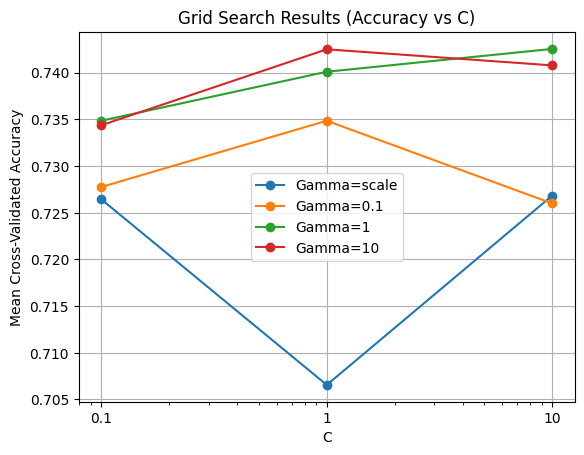

In [ ]:
# Get the mean cross-validated accuracy for each value of C and gamma
mean_scores = grid_search.cv_results_['mean_test_score']
mean_scores = mean_scores.reshape(len(gam_val), -1)  # Reshape for plotting

# Plot the results as a line plot for each gamma value
for i, gamma in enumerate(gam_val):
    plt.plot(C_values, mean_scores[i], marker='o', label=f'Gamma={gamma}')

plt.xlabel('C')
plt.ylabel('Mean Cross-Validated Accuracy')
plt.title('Grid Search Results (Accuracy vs C)')
plt.xscale('log')
plt.xticks(C_values, C_values)
plt.legend()
plt.grid(True)
plt.show()

### Eval on val split

In [ ]:
# Predict the labels for the test data using the best model
best_model = grid_search.best_estimator_
predictions = best_model.predict(valid_df)

# Calculate the accuracy of the best model
accuracy = accuracy_score(valid_labels_df, predictions)
print("Accuracy:", accuracy)

# Calculate the F1 score of the best model
f1 = f1_score(valid_labels_df, predictions)
print("F1 Score:", f1)

Accuracy: 0.7468739980763065
F1 Score: 0.6527380690565208


The RBF SVM did better than the linear SVM

## Best Model

The best model was the RBF SVM. Now I will recreate it using the best params and test it on test split

In [ ]:
# Create an SVM classifier
best_rbf_svm = SVC(kernel='rbf', C=10, gamma='scale', random_state=42)

# Train the SVM classifier
best_rbf_svm.fit(train_df, train_labels_df)

# Predict the labels for data
train_pred = best_rbf_svm.predict(train_df)
test_pred = best_rbf_svm.predict(test_df)

# Calculate the accuracy of the model
train_accuracy = accuracy_score(train_labels_df, train_pred)
test_accuracy = accuracy_score(test_labels_df, test_pred)

print("Train Accuracy: ", train_accuracy)
print("Test Accuracy: ", test_accuracy)

Train Accuracy:  0.7575453926009058
Test Accuracy:  0.739899961523663


In [ ]:
print(classification_report(test_labels_df, test_pred, target_names=label_names))

              precision    recall  f1-score   support

  non-smoker       0.79      0.80      0.80      4933
      smoker       0.65      0.64      0.64      2864

    accuracy                           0.74      7797
   macro avg       0.72      0.72      0.72      7797
weighted avg       0.74      0.74      0.74      7797



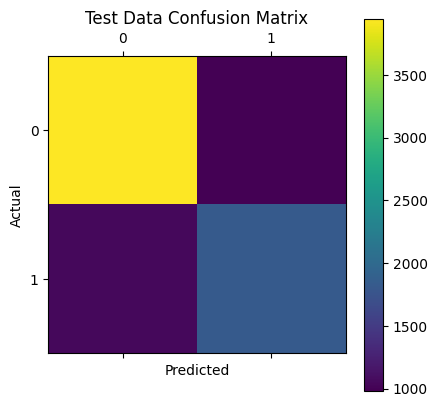

In [ ]:
#Create and visualize Confusion Matrix for model predictions of the test data
test_cm = confusion_matrix(test_labels_df, test_pred)
plt.matshow(test_cm)
plt.title('Test Data Confusion Matrix')
plt.colorbar()
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()